# rozpoznawanie typów zgłoszeń DOP

In [1]:
import sys, os, re, time
import pandas as pd
import numpy as np
#import seaborn as sn
import matplotlib.pyplot as plt

# import random
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler
import fastText

#import tensorflow as tf
#from tensorflow.keras import models
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras import regularizers

#from tensorflow.keras import backend as K

## przygotowanie danych

In [2]:
datapath='/mnt/c/dev/DOP-categories/'
datafile='Cases categorization.xlsx'
dane_surowe=pd.read_excel(os.path.join(datapath,datafile))


In [3]:
#dane_surowe.info()

In [4]:
dane_surowe.columns

Index(['casenumber', 'jira', 'contactemail', 'origin', 'status', '_type',
       'record_name', 'record_desc', 'createddate', 'lastmodifieddate',
       'closeddate', 'moneyrefund', 'owner_name', 'lastmod_name', 'case_desc',
       'Unnamed: 15'],
      dtype='object')

In [5]:
input_data=pd.DataFrame()
input_data[['content','category']]=dane_surowe[['case_desc','Unnamed: 15']]

In [6]:
input_data.head()

,content,category
0,Problem z wyświetlaniem informacji w FAQ - w ...,FAQ; wrong copy;
1,W żadnej z kategorii nie ma sekcji 'najczęstsz...,FAQ; content categorization;
2,moje konto> mój plan > szczegóły oferty aplika...,app crashes
3,Klient zgłsza problem z wyborem numerów. Przy ...,UX
4,Klienta nie może p.rzejść przez weryfikację nu...,OTP


In [7]:
# clearing data
# remove duplicates
input_data.drop_duplicates(inplace=True)
# remove empty
input_data=input_data.dropna()

In [8]:
# find duplicates
input_data[input_data.duplicated(keep=False)]

,content,category


## label freq analysis & selection

In [10]:
def parse_labels(raw_labels):
    label_list=raw_labels.split(';')
    label_list=[x.strip().replace(' ','_') for x in label_list if x != '']
    return label_list


In [11]:
label_lists=input_data['category'].apply(parse_labels)

In [12]:
label_lists.head()

0                [FAQ, wrong_copy]
1    [FAQ, content_categorization]
2                    [app_crashes]
3                             [UX]
4                            [OTP]
Name: category, dtype: object

In [13]:
from itertools import chain
from collections import Counter
label_count=Counter(chain.from_iterable(label_lists.values))

<BarContainer object of 87 artists>

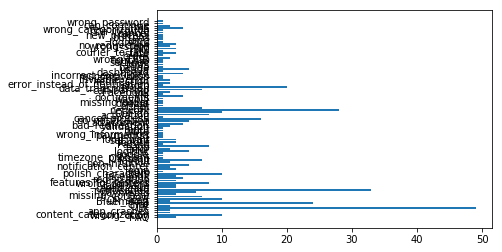

In [14]:
plt.barh(list(label_count.keys()),list(label_count.values()))

In [15]:
min_label_freq=5  # minimum occurencies to be used in 
pruned_label_count = {key:value for (key,value) in label_count.items() if value>=min_label_freq}

<BarContainer object of 22 artists>

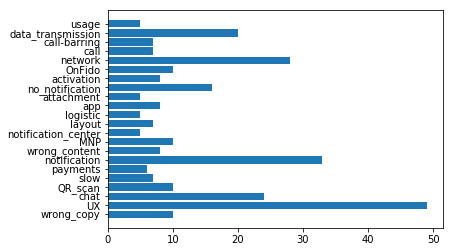

In [16]:
plt.barh(list(pruned_label_count.keys()),list(pruned_label_count.values()))

In [17]:
interesting_labels=list(pruned_label_count.keys())
pd.Series(interesting_labels).to_csv(os.path.join(datapath,'interesting_labels.csv'),header=['label'],index=False)


## preprocessing

### preprocessing content text

In [18]:
# Słownik synonimów / podmian

podmiany=pd.read_excel(os.path.join(datapath,'preproc_dict.xlsx'))

In [19]:
def preprocess_texts(raw_texts,replacements):
    """
    texts: np.Series containing strings to be preprocessed
    replacements: pairs of what convert to what
    return np.Series with corrected texts
    """
    resulttext=raw_texts.str.lower()
    for [co,naco,_] in replacements.values:
        resulttext=resulttext.str.replace(re.compile(str(co)),str(naco))
    return resulttext


In [20]:
prep_texts=preprocess_texts(input_data['content'],podmiany)

In [21]:
prep_texts[0]

'problem z wyświetlaniem informacji w faq w kategorii faq ogólne pierwszy artykuł ma tytuł tytuł dokumentu i treść przykładowy konwent dokumentu login _email msisdn _phonenumber numer zamówienia _number wystąpiło _number _number _number _number _number jira dsd _number'

### preprocessing labels

In [22]:
interesting_labels=pd.read_csv(os.path.join(datapath,'interesting_labels.csv'))

In [23]:
def preprocess_labels(raw_labels, interesting_labels):
    result_labels=raw_labels.split(';')  # split on ';'
    # remove leading space and replace spaces inside to underscore
    result_labels=[x.strip().replace(' ','_') for x in result_labels]
    #remove not interesting labels
    result_labels=[x for x in result_labels if x in interesting_labels]
    return result_labels

In [24]:

prep_labels=input_data['category'].apply(preprocess_labels, args=(interesting_labels.values,))

In [25]:
prep_labels.head()

0    [wrong_copy]
1              []
2              []
3            [UX]
4              []
Name: category, dtype: object

In [ ]:
interesting_labels

In [26]:
texts_train,texts_val,y_train,y_val=train_test_split(prep_texts.values, prep_labels.values,
                                                     test_size=0.25,random_state=1, shuffle=True)

In [27]:
#save file for fasttext emb
pd.Series(texts_train).to_csv(os.path.join(datapath,'texts_for_emb.txt'),sep='\n',index=False)

In [32]:
# oversampling to boost minority classes
ros = RandomOverSampler(random_state=0)

texts_train, y_train = ros.fit_resample(np.reshape(texts_train, (-1, 1)),y_train)

# shuffle to be sure 
texts_train, y_train = shuffle(texts_train, y_train, random_state=0)

texts_train=texts_train.reshape(-1)

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead.

In [28]:
# prepare files for fasstext
def prepare_fasttext(texts, labels):
    fasttext_set=[]
    for i,l in enumerate(labels):
        l=['__label__'+x for x in l]
        labs=' '.join(l) 
        fasttext_set.append(labs + ' ' + texts[i])
    return fasttext_set

# prepare for train and validation data
fasttext_train_set=prepare_fasttext(texts_train, y_train)
fasttext_val_set=prepare_fasttext(texts_val, y_val)

# save in files
pd.Series(fasttext_train_set).to_csv(os.path.join(datapath,'fasttext_train.txt'),sep='\n',index=False)
pd.Series(fasttext_val_set).to_csv(os.path.join(datapath,'fasttext_val.txt'),sep='\n',index=False)
# use validation data for test
pd.Series(texts_val).to_csv(os.path.join(datapath,'fasttest_test.txt'),sep='\n',index=False)

In [29]:
# training
classifier = fastText.train_supervised(os.path.join(datapath,'fasttext_train.txt'),epoch=5000)

In [30]:
classifier.save_model(os.path.join(datapath,'model'))

In [31]:
classifier.test(os.path.join(datapath,'fasttext_val.txt'), k=1)

(45, 0.5333333333333333, 0.3287671232876712)

## predictions

In [34]:
texts_test=pd.read_csv(os.path.join(datapath,'fasttest_test.txt'), header=None)
test_set=preprocess_texts(texts_test[0],podmiany)

In [35]:
test_set.values.shape

(47,)

In [36]:
def make_predictions(clf, texts):
    predictions=[]
    for t in texts:
        labels, probs = clf.predict(t,k=5,threshold=0.1)
        result_line=''
        # print(f'labels:{labels}')
        # print(f'probs:{probs}')
        for i,l in enumerate(labels):
            # print(f'i:{i} l:{l} probs[i]:{probs[i]}')
            l=l.replace('__label__','')
            result_line+=l + ': ' + str(probs[i]) + '; '
        # print(f'result_line: {result_line}')
        predictions.append(result_line)
    return predictions
    

In [37]:
result = make_predictions(classifier, test_set.values)

In [42]:
pd.Series(result).to_csv(os.path.join(datapath,'predictions.csv'),index=False)

## result analysis

In [43]:
y_val_predicted=pd.read_csv(os.path.join(datapath,'predictions.csv'), header=None)

In [44]:
y_val_pred=y_val_predicted.values
#print(y_val_predicted)
print(y_val_pred.shape)

(47, 1)


calculate statistics per class

In [46]:
#y_prob = mymodel.predict(x_val) 
#y_preds = y_prob.argmax(axis=-1)
y_preds = y_val_pred
cm = metrics.confusion_matrix(y_val, y_preds)

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead.

In [ ]:
print(metrics.classification_report(list(y_val),list(y_preds),labels=[1,2,3,4],target_names=label_dict[1:]))
#print(metrics.classification_report(list(y_val),list(y_preds),target_names=label_dict))

In [ ]:
cm

In [ ]:
df_cm = pd.DataFrame(cm, label_dict, label_dict)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [ ]:
pd.Series(y_val).value_counts()

In [ ]:
print(mymodel.summary())

In [ ]:
y_prob_train = mymodel.predict(x_train) 
y_preds_train = y_prob_train.argmax(axis=-1)
cm_train = metrics.confusion_matrix(y_train, y_preds_train)

In [ ]:
cm_train

In [ ]:
df_cm_train = pd.DataFrame(cm_train, label_dict, label_dict)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm_train, annot=True, annot_kws={"size": 12})# font size